# 1 - Practice NetworkX Package

In [1]:
import networkx as nx

## 1.1 - Create a Graph

In [2]:
# undirected graph
G = nx.Graph()
print(G.is_directed())

False


In [3]:
# directed graph
DG = nx.DiGraph()
print(DG.is_directed())

True


In [4]:
# undirected multi-graph: allow self-loop
MG = nx.MultiGraph()
print(MG.is_directed())
print(MG.is_multigraph())

False
True


In [5]:
# directed multi-graph
MDG = nx.MultiDiGraph()
print(MDG.is_directed())
print(MDG.is_multigraph())

True
True


## 1.2 - Node

In [6]:
# add one node
G.add_node(0, feature=3, label=0)
print(G)

Graph with 1 nodes and 0 edges


In [7]:
# list nodes
G.nodes(data=True)

NodeDataView({0: {'feature': 3, 'label': 0}})

In [8]:
# get node
G.nodes[0]

{'feature': 3, 'label': 0}

In [9]:
# add multiple nodes with attributes
G.add_nodes_from([
    (1, {'feature': 1, 'label': 0}),
    (2, {'feature': 2, 'label': 1})
])
print(G)

Graph with 3 nodes and 0 edges


In [10]:
G.nodes(data=True)

NodeDataView({0: {'feature': 3, 'label': 0}, 1: {'feature': 1, 'label': 0}, 2: {'feature': 2, 'label': 1}})

## 1.3 - Edge

In [11]:
# add one edge between node #0 and node #1
G.add_edge(0, 1, weight=0.1)
print(G)

Graph with 3 nodes and 1 edges


In [12]:
# add a series of nodes
G.add_edges_from([
    (1, 2, {'weight': 0.5}),
    (0, 2, {'weight': 1})
])
print(G)

Graph with 3 nodes and 3 edges


In [13]:
# list edges
G.edges(data=True)

EdgeDataView([(0, 1, {'weight': 0.1}), (0, 2, {'weight': 1}), (1, 2, {'weight': 0.5})])

## 1.4 - Node Degrees

In [14]:
# node #0's degress
G.degree[0]

2

## 1.5 - Visualize the graph

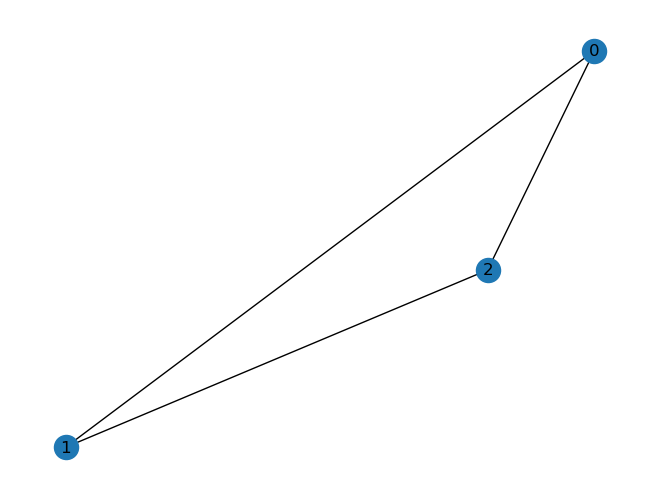

In [15]:
nx.draw(G, with_labels=True)

# 2 - Practice PyTorch Geometric Package

In [16]:
import torch
print(torch.__version__)

2.4.1


## 2.1 Try built-in dataset

In [17]:
from torch_geometric.datasets import KarateClub

In [18]:
dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


Only one graph is included. Let's examine this graph.

In [19]:
data = dataset[0]

In [20]:
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


- `x`: 34 nodes and each of them is represented by 34-dimensional vector
- `edge_index`: 156 edges where 1st and 2nd elements are starting and ending nodes
- `y`: the target label for each node
- `train_mask`: the mask used to separate training and testing nodes

In [21]:
print(data.num_nodes)
print(data.num_edges)
print(data.train_mask)
print(data.has_isolated_nodes())
print(data.has_self_loops())
print(data.is_undirected())

34
156
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])
False
False
True


In [22]:
# node #1 and node #2 has an edge
print(data.edge_index.T[0])

tensor([0, 1])


## 2.2 Visualize the data

In [23]:
# convert from pytorch data object to networkx object
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)

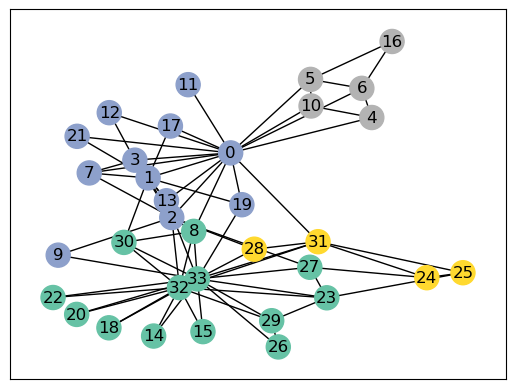

In [24]:
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True, node_color=data.y, cmap='Set2')

# 3 - Build a simple graph neural network

GNN takes an input of graph $\mathbb{G} = (\mathbb{V}, E)$ where each node $v_i \in \mathbb{V}$ has a feature vector $X_i$.

GNN learns a function $f_G: \mathbb{V} \times \mathbb{R}^{d_1} \rightarrow \mathbb{R}^{d_2}$ which takes (1) the nodes, (2) the associated feature vector, and (3) the graph structure and outputs an embedding vector. This generated embedding vector may help us to perform the downstream task such as finding similar pairs or classifying node's target.

The GNN below is created for classifying node's target response.

In [25]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

## 3.1 - Implement GNN structure

In [26]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h1 = self.conv1(x, edge_index)
        h1 = h1.tanh()
        h2 = self.conv2(h1, edge_index)
        h2 = h2.tanh()
        h3 = self.conv3(h2, edge_index)
        h3 = h3.tanh() 

        # Apply a final (linear) classifier.
        out = self.classifier(h3)

        return out, h3

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [27]:
# initialize the model without training
model = GCN()

out, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

Embedding shape: [34, 2]


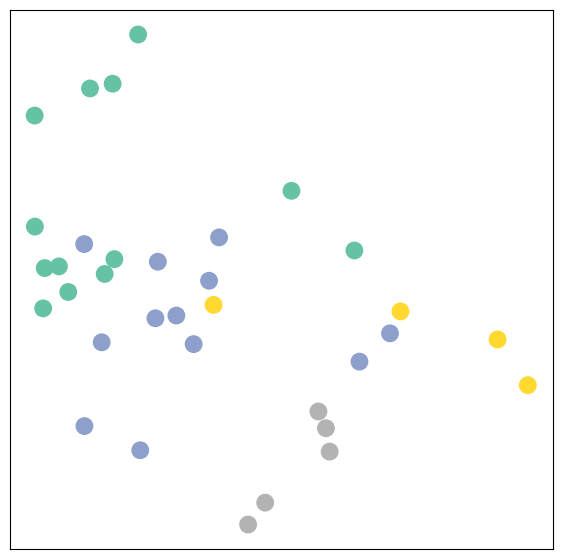

In [28]:
# Visalize the model output without training
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.xticks([])
plt.yticks([])
# make sure it works with gpu or cpu tensor
if h.is_cuda:
    hnp = h.detach().cpu().numpy()
else:
    hnp = h.detach().numpy()
plt.scatter(hnp[:, 0], hnp[:, 1], s=140, c=data.y, cmap="Set2")
plt.show()

This plot shows that, even without the model training, the node with same colors are already placed close to each other in the embedding space.

## 3.2 - GNN training

In [29]:
print(data.train_mask)

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


Four nodes are available for training and the rest 30 nodes can be used for testing.

In [30]:
# Initialize the model
model = GCN()
# Define loss function
loss_fun = torch.nn.CrossEntropyLoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# training function
def train(data):
    # clear gradient; torch use cumulated gradient
    optimizer.zero_grad()
    # forward pass
    out, h = model(data.x, data.edge_index)
    # loss: only on the training nodes
    loss = loss_fun(out[data.train_mask], data.y[data.train_mask])
    # backward
    loss.backward()
    # update parameters
    optimizer.step()

    # record the training metric
    accuracy = {}
    predicted_classes = torch.argmax(out[data.train_mask], axis=1)
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(torch.where(predicted_classes==target_classes, 1, 0).float())

    # record the metric on entire population
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['whole'] = torch.mean(torch.where(predicted_classes==target_classes, 1, 0).float())

    return loss, h, accuracy

In [31]:
%%time
for epoch in range(0, 500):
    loss, h, accuracy = train(data)

    if epoch % 100 == 0:
        print(f'At {epoch}, the training accuracy is {accuracy["train"]} and the whole accuracy is {accuracy["whole"]}')

At 0, the training accuracy is 0.25 and the whole accuracy is 0.3529411852359772
At 100, the training accuracy is 1.0 and the whole accuracy is 0.7941176295280457
At 200, the training accuracy is 1.0 and the whole accuracy is 0.7941176295280457
At 300, the training accuracy is 1.0 and the whole accuracy is 0.8235294222831726
At 400, the training accuracy is 1.0 and the whole accuracy is 0.8235294222831726
CPU times: total: 0 ns
Wall time: 577 ms


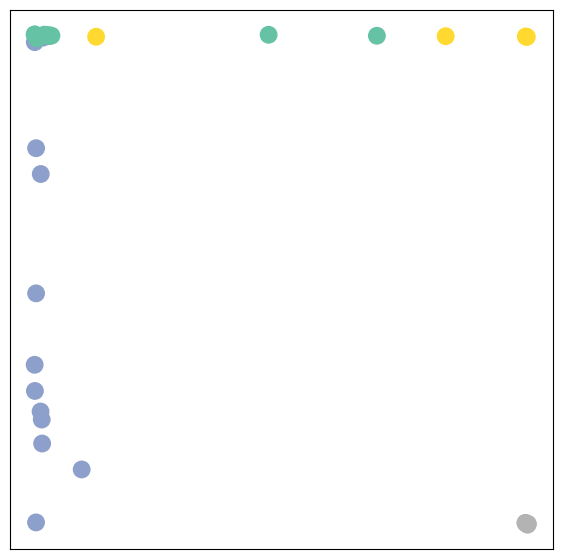

In [32]:
# Visalize the model output without training
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.xticks([])
plt.yticks([])
# make sure it works with gpu or cpu tensor
if h.is_cuda:
    hnp = h.detach().cpu().numpy()
else:
    hnp = h.detach().numpy()
plt.scatter(hnp[:, 0], hnp[:, 1], s=140, c=data.y, cmap="Set2")
plt.show()

The GNN model separates the communities pretty well and assigns the correct target to the node.